# TKAN example and comparison with benchmarks

All test have been run on a RTX 4070 with an Core™ i7-6700K on vast.ai using this [jax docker image](https://hub.docker.com/r/bitnami/jax/)

tkan version: 0.4.1

In [13]:
!pip install pandas numpy matplotlib pyarrow scikit-learn tkan "jax[cuda12]"

INFO: pip is looking at multiple versions of jax[cuda12] to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax[cuda12] to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/25.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/25.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/25.1 MB ? eta -:--:--
    --------------------------------------- 0.5/25.1 MB 390.1 kB/s eta 0:01:04
    --------------------------------------- 0.5/25.1 MB 390.1 kB/s eta 0:01:04
    --------------------------------------- 0.5/25

In [1]:
import os
BACKEND = 'torch' # You can use any backend here 
os.environ['KERAS_BACKEND'] = BACKEND

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader,Dataset
import torch
import torch.nn as nn
# 创建目录（如果不存在）
os.makedirs('model', exist_ok=True)

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Flatten, GRU

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from tkan import TKAN




# Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split

class BatterySOCDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.features[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.float32)
        )

def getData_ANN(train_files, test_file, batch_size, batch_size1, shuf):
    # 读取训练集
    train_data = pd.concat([pd.read_csv(file) for file in train_files], ignore_index=True)
    train_data.drop('Profile', axis=1, inplace=True)

    # 提取特征和标签
    features = train_data.iloc[:, :3].values  # 除了最后一列SOC
    labels = train_data.iloc[:, -1].values     # SOC作为标签

    # 归一化特征
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)
    trainx, trainy = features, labels

    # 读取测试集
    test_data = pd.concat([pd.read_csv(file) for file in test_file], ignore_index=True)
    test_data.drop('Profile', axis=1, inplace=True)
    test_features = test_data.iloc[:, :3].values
    test_labels = test_data.iloc[:, -1].values
    test_features = scaler.transform(test_features)
     # 为测试集特征添加0.5%的高斯白噪声
    noise_std = 0.005 * np.std(test_features)  # 计算0.5%的标准差
    # test_features = test_features + np.random.normal(0, noise_std, test_features.shape)

    # 构建DataLoader
    train_loader = DataLoader(dataset=BatterySOCDataset(trainx, trainy), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=BatterySOCDataset(test_features, test_labels), batch_size=batch_size1, shuffle=shuf)
    

    # SOC的最大最小值（用于反归一化）
    close_max = labels.max()
    close_min = labels.min()

    return train_loader, test_loader

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split

class BatterySOCDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.features[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.float32)
        )

def getData(train_files, test_file, batch_size, batch_size1, shuf, sequence):
    # 读取训练集 CSV 文件
    train_data = pd.concat([pd.read_csv(file) for file in train_files], ignore_index=True)

    # 数据预处理
    train_data.drop('Profile', axis=1, inplace=True)
    close_max = train_data['SOC'].max()  # SOC的最大值
    close_min = train_data['SOC'].min()  # SOC的最小值

    # 提取特征和标签
    features = train_data.iloc[:, :3].values  # 所有列除了最后一列
    labels = train_data.iloc[:, -1].values  # 最后一列为 SOC 标签

    # 归一化特征
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)

    # 按文件划分序列
    train_sequences = []
    train_labels = []
    
    start_idx = 0
    for file in train_files:
        file_data = pd.read_csv(file)
        file_data.drop('Profile', axis=1, inplace=True)

        file_features = file_data.iloc[:, :3].values
        file_labels = file_data.iloc[:, -1].values

        # 归一化每个文件的特征
        file_features = scaler.transform(file_features)

        num_samples = len(file_features) - sequence+1
        file_X = np.array([file_features[i:(i + sequence)] for i in range(0,num_samples)], dtype=np.float32)
        file_Y = np.array([file_labels[i + sequence-1] for i in range(0,num_samples)], dtype=np.float32)
        train_sequences.append(file_X)
        train_labels.append(file_Y)

    # 将所有文件的序列拼接到一起
    X = np.concatenate(train_sequences, axis=0)
    Y = np.concatenate(train_labels, axis=0)


    # 划分训练集
    total_len = len(Y)
    trainx, trainy = X, Y  # 全部作为训练集

    # 读取测试集 CSV 文件
    test_data = pd.concat([pd.read_csv(file) for file in test_file], ignore_index=True)
    test_data.drop('Profile', axis=1, inplace=True)

    # 提取特征和标签
    test_features = test_data.iloc[:, :3].values  # 所有列除了最后一列
    test_labels = test_data.iloc[:, -1].values  # 最后一列为 SOC 标签

    # 归一化测试集特征（使用训练集的缩放器）
    test_features = scaler.transform(test_features)
    
    # 为测试集特征添加0.5%的高斯白噪声
    noise_std = 0.005 * np.std(test_features)  # 计算0.5%的标准差
    test_features_noisy = test_features + np.random.normal(0, noise_std, test_features.shape)
    
    # 按文件划分序列
    test_sequences = []
    test_labels_final = []
    
    for file in test_file:
        file_data = pd.read_csv(file)
        file_data.drop('Profile', axis=1, inplace=True)

        file_features = file_data.iloc[:, :3].values
        file_labels = file_data.iloc[:, -1].values

        # 归一化每个文件的特征
        file_features = scaler.transform(file_features)
        
        # 为每个文件的测试数据添加相同的噪声比例
        file_features = file_features + np.random.normal(0, noise_std, file_features.shape)

        num_samples = len(file_features) - sequence+1
        file_X = np.array([file_features[i:(i + sequence)] for i in range(0,num_samples)], dtype=np.float32)
        file_Y = np.array([file_labels[i + sequence-1] for i in range(0,num_samples)], dtype=np.float32)
        test_sequences.append(file_X)
        test_labels_final.append(file_Y)

    # 将所有文件的序列拼接到一起
    test_X = np.concatenate(test_sequences, axis=0)
    test_Y = np.concatenate(test_labels_final, axis=0)

    # 构建DataLoader，用于批次训练
    train_loader = DataLoader(dataset=BatterySOCDataset(trainx, trainy), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=BatterySOCDataset(test_X, test_Y), batch_size=batch_size1, shuffle=shuf)
    

    return train_loader, test_loader

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split

class BatterySOCDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.features[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.float32)
        )

def getData(train_files, test_file, batch_size, batch_size1, shuf, sequence):
    # 读取训练集 CSV 文件
    train_data = pd.concat([pd.read_csv(file) for file in train_files], ignore_index=True)

    # 数据预处理
    train_data.drop('Profile', axis=1, inplace=True)
    close_max = train_data['SOC'].max()  # SOC的最大值
    close_min = train_data['SOC'].min()  # SOC的最小值

    # 提取特征和标签
    features = train_data.iloc[:, :3].values  # 所有列除了最后一列
    labels = train_data.iloc[:, -1].values  # 最后一列为 SOC 标签

    # 归一化特征
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)

    # 按文件划分序列
    train_sequences = []
    train_labels = []
    
    start_idx = 0
    for file in train_files:
        file_data = pd.read_csv(file)
        file_data.drop('Profile', axis=1, inplace=True)

        file_features = file_data.iloc[:, :3].values
        file_labels = file_data.iloc[:, -1].values

        # 归一化每个文件的特征
        file_features = scaler.transform(file_features)

        num_samples = len(file_features) - sequence+1
        file_X = np.array([file_features[i:(i + sequence)] for i in range(0,num_samples)], dtype=np.float32)
        file_Y = np.array([file_labels[i + sequence-1] for i in range(0,num_samples)], dtype=np.float32)
        train_sequences.append(file_X)
        train_labels.append(file_Y)

    # 将所有文件的序列拼接到一起
    X = np.concatenate(train_sequences, axis=0)
    Y = np.concatenate(train_labels, axis=0)

    # 划分训练集
    trainx, trainy = X, Y  # 全部作为训练集

    # 读取测试集 CSV 文件
    test_data = pd.concat([pd.read_csv(file) for file in test_file], ignore_index=True)
    test_data.drop('Profile', axis=1, inplace=True)
    
    # 按文件划分序列
    test_sequences = []
    test_labels_final = []
    
    for file in test_file:
        file_data = pd.read_csv(file)
        file_data.drop('Profile', axis=1, inplace=True)

        file_features = file_data.iloc[:, :3].values
        file_labels = file_data.iloc[:, -1].values

        # 归一化每个文件的特征
        file_features = scaler.transform(file_features)

        num_samples = len(file_features) - sequence+1
        file_X = np.array([file_features[i:(i + sequence)] for i in range(0,num_samples)], dtype=np.float32)
        file_Y = np.array([file_labels[i + sequence-1] for i in range(0,num_samples)], dtype=np.float32)
        test_sequences.append(file_X)
        test_labels_final.append(file_Y)

    # 将所有文件的序列拼接到一起
    test_X = np.concatenate(test_sequences, axis=0)
    test_Y = np.concatenate(test_labels_final, axis=0)

    # 构建DataLoader，用于批次训练
    train_loader = DataLoader(dataset=BatterySOCDataset(trainx, trainy), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=BatterySOCDataset(test_X, test_Y), batch_size=batch_size1, shuffle=shuf)
    

    return train_loader, test_loader

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Reshape,Permute,BatchNormalization,SimpleRNN,GlobalAveragePooling1D
from keras.layers import Input, Concatenate,Dropout,Layer,Bidirectional,GRU,Activation, Dropout, Add, Dense, Lambda,LayerNormalization,MultiHeadAttention
from torch.optim.lr_scheduler import OneCycleLR,StepLR
from torch.optim import adamw
from torch.optim import SGD
import torch
from torch_optimizer import Lamb
from keras.regularizers import l2,l1
# import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tcn import TCN  # 从keras-tcn库中导入TCN层
from matplotlib import font_manager
import tensorflow as tf
from keras_efficient_kan import KANLinear
from tcn import TCN 
from keras_transformer import get_model
from keras_self_attention import SeqSelfAttention
# import keras_nlp

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
font_path = 'C:/Windows/Fonts/simsun.ttc'  # 示例：使用微软雅黑
font_prop = font_manager.FontProperties(fname=font_path)

# transformer CNNtransformer
# # 参数
# sequence_length = 200
# feature_dim = 3
# embed_dim = 64
# num_heads = 4
# ff_dim = 128
# num_layers = 2


# class PositionalEncoding(tf.keras.layers.Layer):
#     def __init__(self, sequence_length, embed_dim):
#         super().__init__()
#         self.position_embed = keras.layers.Embedding(
#             input_dim=sequence_length, 
#             output_dim=embed_dim
#         )
    
#     def call(self, inputs):
#         positions = tf.range(start=0, limit=sequence_length, delta=1)
#         return inputs + self.position_embed(positions)

# def transformer_encoder(x, num_heads, embed_dim, ff_dim):
#     # 多头注意力
#     attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
#     
#     x = LayerNormalization(epsilon=1e-6)(x + attn_output)
    
#     # FeedForward
#     ff_output = Dense(ff_dim, activation="relu")(x)
#     ff_output = Dense(embed_dim)(ff_output)
#    
#     x = LayerNormalization(epsilon=1e-6)(x + ff_output)
#     return x

# model_input = Input(shape=(200,3))

# x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model_input)  # (None, 5, 32)
# # 特征升维 + 位置编码
# x = Dense(embed_dim)(x)
# x = PositionalEncoding(sequence_length, embed_dim)(x)

# # 堆叠Transformer编码器
# for _ in range(num_layers):
#     x = transformer_encoder(x, num_heads, embed_dim, ff_dim)

# # 取最后一个时间步 [batch_size, embed_dim]
# last_timestep = x[:, -1, :]
# output = Dense(units=1, activation='linear')(last_timestep)


# KANGRID4
# model_input = Input(shape=(3,))
# # # x = Dense(units=100, activation='linear')(model_input)
# x = KANLinear(100, use_layernorm=False)(model_input)
# x = KANLinear(100, use_layernorm=False)(x)
# x = KANLinear(100, use_layernorm=False)(x)
# x = KANLinear(100, use_layernorm=False)(x)
# output = Dense(units=1, activation='linear')(x)

# MLP
# x = Dense(units=70, activation='relu')(model_input)
# x = Dense(units=70, activation='relu')(x)
# x = Dense(units=70, activation='relu')(x)
# x = Dense(units=70, activation='relu')(x)
# output = Dense(units=1, activation='linear')(x)

# TKAN,LSTM,GRU,TCN,CNNGRU,CNNLSTM
model_input = Input(shape=(200,3))

# # TCN 层
# x = TCN(nb_filters=256,kernel_size=7, dilations=[1,2,4,8])(model_input)

# output = Dense(units=1, activation='linear')(x)

# 添加卷积层
# x = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(model_input)  # (None, 10, 16)
# x = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(x)  # (None, 5, 32)
# x = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(x)  # (None, 5, 32)


x= TKAN(100,sub_kan_output_dim = 200, sub_kan_input_dim = 100, return_sequences=True)(model_input)
lstm_output2= TKAN(100,sub_kan_output_dim = 200, sub_kan_input_dim = 100, return_sequences=False)(x)

# x=LSTM(60,return_sequences=True)(model_input)
# lstm_output2=LSTM(60,return_sequences=False)(x)

# x=GRU(100,return_sequences=True)(model_input)
# lstm_output2=GRU(100,return_sequences=False)(x)
# # 最后输出层
output = Dense(units=1, activation='linear')(lstm_output2)

# 创建模型
model = Model(inputs=model_input, outputs=output)
model.to(device)

lr_values = []
criterion = nn.MSELoss()  # 定义损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam梯度下降  学习率=0.001

total_params = model.count_params()
print(f"Total params: {total_params:,}")

train_files = ['E:/python/TKAN-main(1)/TKAN-main/data/20C/DST_20.csv', 'E:/python/TKAN-main(1)/TKAN-main/data/20C/FUDS_20.csv','E:/python/TKAN-main(1)/TKAN-main/data/25C/DST_25.csv', 'E:/python/TKAN-main(1)/TKAN-main/data/25C/FUDS_25.csv',
               'E:/python/TKAN-main(1)/TKAN-main/data/30C/DST_30.csv','E:/python/TKAN-main(1)/TKAN-main/data/30C/FUDS_30.csv','E:/python/TKAN-main(1)/TKAN-main/data/40C/DST_40.csv','E:/python/TKAN-main(1)/TKAN-main/data/0C/DST_0.csv'
                   ,'E:/python/TKAN-main(1)/TKAN-main/data/40C/FUDS_40.csv','E:/python/TKAN-main(1)/TKAN-main/data/50C/DST_50.csv','E:/python/TKAN-main(1)/TKAN-main/data/50C/FUDS_50.csv','E:/python/TKAN-main(1)/TKAN-main/data/0C/FUDS_0.csv'
                   ,'E:/python/TKAN-main(1)/TKAN-main/data/10C/DST_10.csv', 'E:/python/TKAN-main(1)/TKAN-main/data/10C/FUDS_10.csv']
test_file = ['E:/python/TKAN-main(1)/TKAN-main/data/20C/US06_20.csv','E:/python/TKAN-main(1)/TKAN-main/data/0C/US06_0.csv','E:/python/TKAN-main(1)/TKAN-main/data/30C/US06_30.csv','E:/python/TKAN-main(1)/TKAN-main/data/25C/US06_25.csv',
             'E:/python/TKAN-main(1)/TKAN-main/data/40C/US06_40.csv','E:/python/TKAN-main(1)/TKAN-main/data/50C/US06_50.csv','E:/python/TKAN-main(1)/TKAN-main/data/10C/US06_10.csv']

batch_size =1024
# train_loader, test_loader , close_max, close_min = getData_ANN(train_files, test_file, batch_size,batch_size1=8192,shuf=True)KAN,MLP
train_loader, test_loader  = getData(train_files, test_file, batch_size,batch_size1=8192,shuf=True,sequence=200)

scheduler = StepLR(optimizer,step_size=10,gamma=0.9)

epoch_losses = []
labels = []  # 用于保存所有的真实值
preds = []  # 用于保存所有的预测值
best_rmse = float('inf')  # 初始化最佳RMSE为无穷大
best_r2 = -float('inf')  # 初始化最佳R^2为负无穷大
best_loss = float('inf')  # 初始化最佳R^2为负无穷大
batch_train_losses = []  # 记录每个batch的测试损失
train_rmse_list = []  # 记录每个epoch的训练集RMSE
test_rmse_list = []  # 记录每个epoch的测试集RMSE
test_epoch_losses = []

with open('0.2CNNTKAN_loss_log1no验证grid3,无限.txt', 'w') as f,open('0.2Gtest_loss_logCNNTKAN1no验证grid3,无限.txt', 'w') as f_rmse:
    for i in range(400):  # 循环遍历每个epoch
        test_loss = 0
        valid_loss = 0
        train_rmse = 0  # 初始化当前epoch的RMSE
        total_loss = 0  # 初始化当前epoch的总损失
        all_labels = []  # 存储当前 epoch 的真实值
        all_preds = []  # 存储当前 epoch 的预测值
        for idx, (data ,label) in enumerate(train_loader):
        
            pred= model((data).cuda()) # 将data1封装成Variable并传入模型进行前向传播，得到预测值
            
            label = label.unsqueeze(1).cuda()  # 将标签数据添加一个维度并移动到GPU
                    
            loss = criterion(pred, label) # 计算当前batch的损失值
            optimizer.zero_grad() # 清空优化器的梯度
           
            loss.backward()   # 反向传播，计算梯度
            optimizer.step() # 更新模型参数
           
            total_loss += loss.item()   # 累加当前batch的损失值到total_loss
            rmse = torch.sqrt(nn.MSELoss()(pred, label))  # 均方根误差
            batch_train_losses.append(loss.item())  # 记录每个batch的损失


                # 保存预测值和真实值
            all_preds.append(pred.detach().cpu().numpy())
            all_labels.append(label.detach().cpu().numpy())
            train_rmse += rmse.item()  # 累加当前batch的RMSE

        train_rmse /= len(train_loader)  # 计算平均RMSE
        train_rmse_list.append(train_rmse)  # 添加到训练集RMSE列表
        scheduler.step()        # 获取当前学习率并添加到列表中
        

                # 转换为numpy数组并合并数据
        labels = np.concatenate(all_labels)
        preds = np.concatenate(all_preds)
            # 记录每个epoch的总损失
        epoch_losses.append(total_loss)
            # 在终端输出第多少轮和对应的loss
        print(f'Epoch {i+1}, Loss: {total_loss}')
        print(f'Epoch {i + 1}, rmse: {rmse}')
        # print(f'Epoch {i + 1}, R2: {R2}')
            
            # 将损失写入文件
        f.write(f'Epoch {i+1}, Loss: {total_loss}\n')
       
        model.eval()  # 将模型设置为评估模式
        with torch.no_grad():  # 关闭梯度计算
            test_preds = []
            test_labels = []
            for data, label in test_loader:
                data, label = data.cuda(), label.cuda()
                label = label.unsqueeze(1).cuda()
                pred = model(data)
                test_preds.append(pred.cpu().numpy())
                test_labels.append(label.cpu().numpy())
                # 计算当前批次的损失
                batch_loss = criterion(pred, label)
                test_loss += batch_loss.item()
            
            test_preds = np.concatenate(test_preds)
            test_labels = np.concatenate(test_labels)
            
            # 计算测试集上的RMSE和R^2
            test_loss = nn.MSELoss()(torch.tensor(test_preds), torch.tensor(test_labels))
           
            print(f'Epoch {i + 1}, Test Loss: {test_loss}')
            
            f_rmse.write(f'Epoch {i+1}, Test LOSS: {test_loss}\n')
          
            # 保存最佳模型
            if test_loss<best_loss :
                best_loss = min(best_loss, test_loss)
                # best_r2 = max(best_r2, test_r2)
                torch.save({'state_dict': model.state_dict()},'model/2GRU300.200.100UNIT.XIAJIANG10.0.9.pth')
                print('New best model saved.')
        
        model.train()  # 将模型设置回训练模式
        


Total params: 92,201
Epoch 1, Loss: 6.1860817316919565
Epoch 1, rmse: 0.25325822830200195
Epoch 1, Test Loss: 0.056337080895900726
New best model saved.
Epoch 2, Loss: 3.0886808382347226
Epoch 2, rmse: 0.11826898902654648
Epoch 2, Test Loss: 0.01626112125813961
New best model saved.
Epoch 3, Loss: 0.6191336591728032
Epoch 3, rmse: 0.06458527594804764
Epoch 3, Test Loss: 0.0033097960986196995
New best model saved.
Epoch 4, Loss: 0.3198437348473817
Epoch 4, rmse: 0.053895093500614166
Epoch 4, Test Loss: 0.0023021171800792217
New best model saved.
Epoch 5, Loss: 0.306311103515327
Epoch 5, rmse: 0.05128130316734314
Epoch 5, Test Loss: 0.0021797558292746544
New best model saved.
Epoch 6, Loss: 0.31606109580025077
Epoch 6, rmse: 0.05161287635564804
Epoch 6, Test Loss: 0.0027967977803200483
Epoch 7, Loss: 0.2514874304179102
Epoch 7, rmse: 0.052867770195007324
Epoch 7, Test Loss: 0.0027920901775360107
Epoch 8, Loss: 0.27260532369837165
Epoch 8, rmse: 0.047577112913131714
Epoch 8, Test Loss: 0.

KeyboardInterrupt: 

All predictions shape: (47602, 1), All labels shape: (47602, 1)
预测值和标签已保存到 ZZ.xlsx
Labels shape: (47602, 1), Predictions shape: (47602, 1)
LOSS: 0.000157
RMSE: 0.012522
MAE: 0.009215
r^2: 0.997988


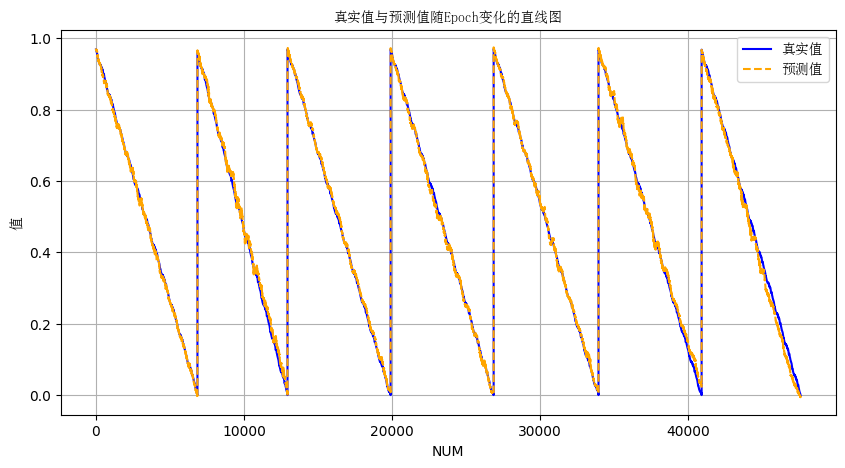

In [ ]:
from matplotlib import font_manager
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Reshape,Dropout
from keras.layers import Input, Concatenate
from keras_efficient_kan import KANLinear
from tcn import TCN 
import tensorflow as tf
from keras.layers import Input, Concatenate,Dropout,Layer,Bidirectional,GRU,Activation, Dropout, Add, Dense, Lambda,LayerNormalization,MultiHeadAttention

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
font_path = 'C:/Windows/Fonts/simsun.ttc'  # 示例：使用微软雅黑
font_prop = font_manager.FontProperties(fname=font_path)

# transformer CNNtransformer
# # 参数
# sequence_length = 200
# feature_dim = 3
# embed_dim = 64
# num_heads = 4
# ff_dim = 128
# num_layers = 2


# class PositionalEncoding(tf.keras.layers.Layer):
#     def __init__(self, sequence_length, embed_dim):
#         super().__init__()
#         self.position_embed = keras.layers.Embedding(
#             input_dim=sequence_length, 
#             output_dim=embed_dim
#         )
    
#     def call(self, inputs):
#         positions = tf.range(start=0, limit=sequence_length, delta=1)
#         return inputs + self.position_embed(positions)

# def transformer_encoder(x, num_heads, embed_dim, ff_dim):
#     # 多头注意力
#     attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
#     
#     x = LayerNormalization(epsilon=1e-6)(x + attn_output)
    
#     # FeedForward
#     ff_output = Dense(ff_dim, activation="relu")(x)
#     ff_output = Dense(embed_dim)(ff_output)
#    
#     x = LayerNormalization(epsilon=1e-6)(x + ff_output)
#     return x

# model_input = Input(shape=(200,3))

# x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model_input)  # (None, 5, 32)
# # 特征升维 + 位置编码
# x = Dense(embed_dim)(x)
# x = PositionalEncoding(sequence_length, embed_dim)(x)

# # 堆叠Transformer编码器
# for _ in range(num_layers):
#     x = transformer_encoder(x, num_heads, embed_dim, ff_dim)

# # 取最后一个时间步 [batch_size, embed_dim]
# last_timestep = x[:, -1, :]
# output = Dense(units=1, activation='linear')(last_timestep)


# KANGRID4
# model_input = Input(shape=(3,))
# # # x = Dense(units=100, activation='linear')(model_input)
# x = KANLinear(100, use_layernorm=False)(model_input)
# x = KANLinear(100, use_layernorm=False)(x)
# x = KANLinear(100, use_layernorm=False)(x)
# x = KANLinear(100, use_layernorm=False)(x)
# output = Dense(units=1, activation='linear')(x)

# MLP
# x = Dense(units=70, activation='relu')(model_input)
# x = Dense(units=70, activation='relu')(x)
# x = Dense(units=70, activation='relu')(x)
# x = Dense(units=70, activation='relu')(x)
# output = Dense(units=1, activation='linear')(x)

# TKAN,LSTM,GRU,TCN,CNNGRU,CNNLSTM
model_input = Input(shape=(200,3))

# # TCN 层
# x = TCN(nb_filters=256,kernel_size=7, dilations=[1,2,4,8])(model_input)

# output = Dense(units=1, activation='linear')(x)

# 添加卷积层
# x = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(model_input)  # (None, 10, 16)
# x = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(x)  # (None, 5, 32)
# x = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(x)  # (None, 5, 32)


x= TKAN(100,sub_kan_output_dim = 200, sub_kan_input_dim = 100, return_sequences=True)(model_input)
lstm_output2= TKAN(100,sub_kan_output_dim = 200, sub_kan_input_dim = 100, return_sequences=False)(x)

# x=LSTM(60,return_sequences=True)(model_input)
# lstm_output2=LSTM(60,return_sequences=False)(x)

# x=GRU(100,return_sequences=True)(model_input)
# lstm_output2=GRU(100,return_sequences=False)(x)
# # 最后输出层
output = Dense(units=1, activation='linear')(lstm_output2)

# # 创建模型
model = Model(inputs=model_input, outputs=output)
model.to(device)  # 将模型移到指定的设备（CPU或GPU）
checkpoint = torch.load('model/2TKAN300.B0.69.GRID1.100UNIT.XIAJIANG10.0.9.pth', weights_only=True)  # 加载模型的状态字典
model.load_state_dict(checkpoint['state_dict']) # 将状态字典加载到模型中
preds = [] # 初始化预测值列表
labels = []  # 初始化真实标签值列表
total_loss = 0
criterion = nn.MSELoss()
    
train_files = ['E:/python/TKAN-main(1)/TKAN-main/data/20C/DST_20.csv', 'E:/python/TKAN-main(1)/TKAN-main/data/20C/FUDS_20.csv','E:/python/TKAN-main(1)/TKAN-main/data/25C/DST_25.csv', 'E:/python/TKAN-main(1)/TKAN-main/data/25C/FUDS_25.csv',
               'E:/python/TKAN-main(1)/TKAN-main/data/30C/DST_30.csv','E:/python/TKAN-main(1)/TKAN-main/data/30C/FUDS_30.csv','E:/python/TKAN-main(1)/TKAN-main/data/40C/DST_40.csv','E:/python/TKAN-main(1)/TKAN-main/data/0C/DST_0.csv'
                   ,'E:/python/TKAN-main(1)/TKAN-main/data/40C/FUDS_40.csv','E:/python/TKAN-main(1)/TKAN-main/data/50C/DST_50.csv','E:/python/TKAN-main(1)/TKAN-main/data/50C/FUDS_50.csv','E:/python/TKAN-main(1)/TKAN-main/data/0C/FUDS_0.csv'
                   ,'E:/python/TKAN-main(1)/TKAN-main/data/10C/DST_10.csv', 'E:/python/TKAN-main(1)/TKAN-main/data/10C/FUDS_10.csv']

test_file = ['E:/python/TKAN-main(1)/TKAN-main/data/20C/US06_20.csv','E:/python/TKAN-main(1)/TKAN-main/data/0C/US06_0.csv','E:/python/TKAN-main(1)/TKAN-main/data/30C/US06_30.csv','E:/python/TKAN-main(1)/TKAN-main/data/25C/US06_25.csv',
             'E:/python/TKAN-main(1)/TKAN-main/data/40C/US06_40.csv','E:/python/TKAN-main(1)/TKAN-main/data/50C/US06_50.csv','E:/python/TKAN-main(1)/TKAN-main/data/10C/US06_10.csv']

batch_size = 2
# train_loader, test_loader , close_max, close_min = getData_ANN(train_files, test_file, batch_size,batch_size1=8192,shuf=False)KAN,MLP
train_loader, test_loader = getData(train_files, test_file, batch_size,batch_size1=4096,shuf=False,sequence=200)

# 初始化存储预测和标签的列表
preds = []
labels = []
model.eval()  # 将模型设置为评估模式
with torch.no_grad():  # 关闭梯度计算
    for idx, (data, label) in enumerate(test_loader):   # 遍历测试数据进行预测
        data = data.cuda()  # Move data to the specified device
        label = label.unsqueeze(1).cuda() # Add dimension and move to device
        pred = model(data)
        preds.append(pred.detach().cpu().numpy())
        labels.append(label.detach().cpu().numpy())

# data=pd.read_csv(r"data/10C/DST_10C.csv")
preds = np.concatenate(preds, axis=0)
labels = np.concatenate(labels, axis=0)
print(f"All predictions shape: {preds.shape}, All labels shape: {labels.shape}")

    # 计算评价指标
mse = nn.MSELoss()(torch.tensor(preds), torch.tensor(labels)) # 均方误差
rmse = torch.sqrt(nn.MSELoss()(torch.tensor(preds), torch.tensor(labels)))  # 均方根误差
mae = torch.mean(torch.abs(torch.tensor(preds) - torch.tensor(labels)))  # 平均绝对误差

r2=r2_score(labels, preds)


labels = np.array(labels)
preds = np.array(preds)
df = pd.DataFrame({
    'True Labels': labels.flatten(),
    'Predictions': preds.flatten()
})

# 定义保存 Excel 文件的路径
excel_filename = 'ZZ.xlsx'

# 保存 DataFrame 到 Excel
df.to_excel(excel_filename, index=False)

print(f"预测值和标签已保存到 {excel_filename}")

print(f"Labels shape: {labels.shape}, Predictions shape: {preds.shape}")
print(f'LOSS: {mse.item():.6f}')
print(f'RMSE: {rmse.item():.6f}')
print(f'MAE: {mae.item():.6f}')
print(f'r^2: {r2:.6f}')

plt.figure(figsize=(10, 5))
plt.plot(labels, label='真实值', color='blue', linestyle='-')
plt.plot(preds, label='预测值', color='orange', linestyle='--')
plt.title('真实值与预测值随Epoch变化的直线图',fontproperties=font_prop)
plt.xlabel('NUM')
plt.ylabel('值',fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.grid()
plt.show()